In [151]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from itertools import product
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

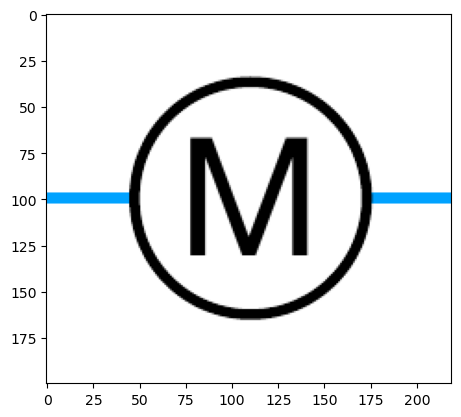

In [62]:
# Import the saved images from the Reader program and save them with a unique name

for i in range(1,89):
    name = f'break_{i}'
    
    %store -r {name}

plt.imshow(break_3)
plt.show()

In [63]:
# Find the dimensions of the largest component

heights = []
widths = []

for x in range(1,89):
    name = f'break_{x}'
    height = globals()[name].shape[0]
    width = globals()[name].shape[1]
    
    heights.append(height)
    widths.append(width)

max_height = max(heights)
max_width = max(widths)

print(f'Max Height: {max_height}')
print(f'Max Width: {max_width}')

Max Height: 200
Max Width: 339


In [64]:
# Make all component arrays the same size to avoid NaN's in the DataFrame and center the component 
# within its array

for x in range(1,89):
    name = f'break_{x}'
    
    # Calculate difference in height + width compared to the largest component
    
    height = globals()[name].shape[0]
    width = globals()[name].shape[1]

    height_delta = max_height - height
    width_delta = max_width - width
    
    # Add the correct amount of white pixels to top, bottom and sides

    top = np.full([round(height_delta/2), width, 3], 255)
    bottom = np.full([height_delta - round(height_delta/2), width, 3], 255)

    globals()[name] = np.concatenate((top, globals()[name], bottom), axis=0)

    height = globals()[name].shape[0]

    left = np.full([height, round(width_delta/2), 3], 255)
    right = np.full([height, width_delta - round(width_delta/2), 3], 255)

    globals()[name] = np.concatenate((left, globals()[name], right), axis=1)
    
    width = globals()[name].shape[1]

In [162]:
# Now convert to DataFrame and add a column for the (known) valve type

df = pd.DataFrame()

for x in range(1,89):
    
    name = f'break_{x}'
    compressed = np.sum(globals()[name],axis = 2) / 3    # Use the mean of all 3 layers for simplicity
    
    
    df = pd.concat([df,pd.DataFrame(compressed.reshape(1,-1))])
    
name_list = []

for i in range(height):
    for j in range(width):
        name_list.append(f'px_{i}_{j}')

df.columns = name_list

df['type'] = [1,2,3,4,1,2,3,4,
              4,3,2,1,4,3,2,1,
              1,2,3,4,1,2,3,4,
              4,3,2,1,4,3,2,1,
              1,2,3,4,1,2,3,4,
              1,3,1,1,1,3,2,1,
              1,2,3,4,1,2,3,4,
              4,3,2,1,4,3,2,1,
              1,2,3,4,1,2,3,4,
              4,3,2,1,4,3,2,1,
              1,2,3,4,1,2,3,4]

print(df)

    px_0_0  px_0_1  px_0_2  px_0_3  px_0_4  px_0_5  px_0_6  px_0_7  px_0_8  \
0    255.0   255.0   255.0   255.0   255.0   255.0   255.0   255.0   255.0   
0    255.0   255.0   255.0   255.0   255.0   255.0   255.0   255.0   255.0   
0    255.0   255.0   255.0   255.0   255.0   255.0   255.0   255.0   255.0   
0    255.0   255.0   255.0   255.0   255.0   255.0   255.0   255.0   255.0   
0    255.0   255.0   255.0   255.0   255.0   255.0   255.0   255.0   255.0   
..     ...     ...     ...     ...     ...     ...     ...     ...     ...   
0    255.0   255.0   255.0   255.0   255.0   255.0   255.0   255.0   255.0   
0    255.0   255.0   255.0   255.0   255.0   255.0   255.0   255.0   255.0   
0    255.0   255.0   255.0   255.0   255.0   255.0   255.0   255.0   255.0   
0    255.0   255.0   255.0   255.0   255.0   255.0   255.0   255.0   255.0   
0    255.0   255.0   255.0   255.0   255.0   255.0   255.0   255.0   255.0   

    px_0_9  ...  px_199_330  px_199_331  px_199_332  px_199_333

In [163]:
# Drop the columns representing pixels that are identical for all pictures (all white or all black)

blk = np.all(df == 0, axis = 0)
wht = np.all(df == 255, axis = 0)

blk_index = blk[blk == True].index
wht_index = wht[wht == True].index

condensed = df.drop(blk_index, axis = 1)

condensed.drop(wht_index, axis = 1, inplace = True)

print(len(condensed.columns))

25181


In [169]:
# Split data and create model

X = condensed.drop('type', axis = 1)
y = condensed.type

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.7)

svc = SVC()

svc.fit(X_train, y_train)

y_pred = svc.predict(X_test)

print(svc.score(X_test, y_test))

for x in range(len(X_test)):
    print(f'Predicted valve type: {y_pred[x]}, Actual valve type: {y_test.iloc[x]}')
    

1.0
Predicted valve type: 2, Actual valve type: 2
Predicted valve type: 3, Actual valve type: 3
Predicted valve type: 2, Actual valve type: 2
Predicted valve type: 2, Actual valve type: 2
Predicted valve type: 1, Actual valve type: 1
Predicted valve type: 3, Actual valve type: 3
Predicted valve type: 1, Actual valve type: 1
Predicted valve type: 2, Actual valve type: 2
Predicted valve type: 4, Actual valve type: 4
Predicted valve type: 1, Actual valve type: 1
Predicted valve type: 4, Actual valve type: 4
Predicted valve type: 1, Actual valve type: 1
Predicted valve type: 2, Actual valve type: 2
Predicted valve type: 4, Actual valve type: 4
Predicted valve type: 3, Actual valve type: 3
Predicted valve type: 4, Actual valve type: 4
Predicted valve type: 3, Actual valve type: 3
Predicted valve type: 1, Actual valve type: 1
Predicted valve type: 1, Actual valve type: 1
Predicted valve type: 4, Actual valve type: 4
Predicted valve type: 3, Actual valve type: 3
Predicted valve type: 2, Actua